<a href="https://colab.research.google.com/github/adrianciemerych/telco_customer_churn_project/blob/main/churn_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing libraries

In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import balanced_accuracy_score, roc_auc_score, f1_score
from sklearn.metrics import precision_score, recall_score, confusion_matrix
from sklearn.metrics import fbeta_score, make_scorer
import time

sns.set()
np.random.seed(42)

# Organizing the data

In [119]:
# Importing dataset
pd.set_option('display.max_columns', None)
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Projects/churn_project/churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [120]:
# Checking info about dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Dataset has 21 columns and each of them doesn't have null values.

In column TotalCharges we can see object data type when it should be float.

In [121]:
# Checking count of values in individual columns
for col in df.columns:
  print(df[col].value_counts())
  print()

7590-VHVEG    1
3791-LGQCY    1
6008-NAIXK    1
5956-YHHRX    1
5365-LLFYV    1
             ..
9796-MVYXX    1
2637-FKFSY    1
1552-AAGRX    1
4304-TSPVK    1
3186-AJIEK    1
Name: customerID, Length: 7043, dtype: int64

Male      3555
Female    3488
Name: gender, dtype: int64

0    5901
1    1142
Name: SeniorCitizen, dtype: int64

No     3641
Yes    3402
Name: Partner, dtype: int64

No     4933
Yes    2110
Name: Dependents, dtype: int64

1     613
72    362
2     238
3     200
4     176
     ... 
28     57
39     56
44     51
36     50
0      11
Name: tenure, Length: 73, dtype: int64

Yes    6361
No      682
Name: PhoneService, dtype: int64

No                  3390
Yes                 2971
No phone service     682
Name: MultipleLines, dtype: int64

Fiber optic    3096
DSL            2421
No             1526
Name: InternetService, dtype: int64

No                     3498
Yes                    2019
No internet service    1526
Name: OnlineSecurity, dtype: int64

No                   

We can see that the customerID column retains 7043 unique rows so it is unnecessary for learning.

It is a correct relationship between column PhoneService and MultipleLines - respectively values "No" in first column and "No phone service" in second column have equal count - 682

As above, a correct relationship is also between column InternetService and columns OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies

Distribution of target is imbalanced. No = 5174, Yes = 1869

In column TotalCharges 11 rows do not have a numeric value. Probably it is a reason why dtype of column isn't float

In [122]:
# Removing customerID column
df = df.drop('customerID', axis = 1)

# Printing info about non-numerical values in TotalCharges
print("Values that are not numbers in TotalCharges: \n",
      list(df.sort_values('TotalCharges').head(11)['TotalCharges']))

Values that are not numbers in TotalCharges: 
 [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']


In [123]:
df.sort_values('TotalCharges').head(12)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
936,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
3826,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
4380,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
753,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
5218,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
3331,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
6754,Male,0,No,Yes,0,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),61.90,,No
6670,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No
1340,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
488,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No


In rows that are inconsistent in term of TotalCharges column, we can see tenure equals to 0. Also the contract is signed for at least on one year and in target column, everywhere churn = 'No', so contract couldn't be broken. These informations may lead to the conclusion that the customers haven't had the opportunity to make a payment yet.

In [124]:
# Replacing string - ' ' to 0
df['TotalCharges'] = df['TotalCharges'].apply(lambda x : 0 if x == ' ' else x)
df['TotalCharges'].value_counts()

0         11
20.2      11
19.75      9
20.05      8
19.9       8
          ..
6849.4     1
692.35     1
130.15     1
3211.9     1
6844.5     1
Name: TotalCharges, Length: 6531, dtype: int64

In [125]:
# Converting column dtypes to int, float or category
for col in df.columns:
  if col in ['tenure']:
    df[col] = df[col].astype(int)
  elif col in ['MonthlyCharges', 'TotalCharges']:
    df[col] = df[col].astype(float)
  else:
    df[col] = df[col].astype('category')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   gender            7043 non-null   category
 1   SeniorCitizen     7043 non-null   category
 2   Partner           7043 non-null   category
 3   Dependents        7043 non-null   category
 4   tenure            7043 non-null   int64   
 5   PhoneService      7043 non-null   category
 6   MultipleLines     7043 non-null   category
 7   InternetService   7043 non-null   category
 8   OnlineSecurity    7043 non-null   category
 9   OnlineBackup      7043 non-null   category
 10  DeviceProtection  7043 non-null   category
 11  TechSupport       7043 non-null   category
 12  StreamingTV       7043 non-null   category
 13  StreamingMovies   7043 non-null   category
 14  Contract          7043 non-null   category
 15  PaperlessBilling  7043 non-null   category
 16  PaymentMethod     7043 n

# Visualizing and describing the data

In [126]:
# Showing statistics about numerical data
df.describe()

,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000
mean,32.371149,64.761692,2279.734304
std,24.559481,30.090047,2266.794470
min,0.000000,18.250000,0.000000
25%,9.000000,35.500000,398.550000
50%,29.000000,70.350000,1394.550000
75%,55.000000,89.850000,3786.600000
max,72.000000,118.750000,8684.800000


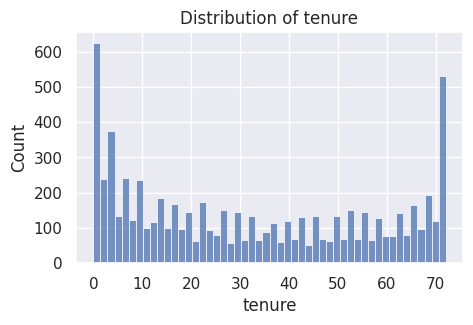

In [127]:
# Visualizing distribution of tenure
plt.figure(figsize = (5,3))
sns.histplot(df['tenure'], bins = 50)
plt.title('Distribution of tenure')
plt.show()

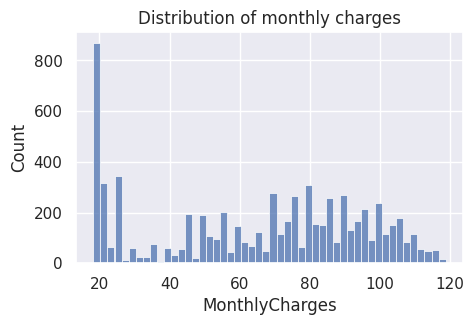

In [128]:
# Visualizing distribution of monthly charges
plt.figure(figsize = (5,3))
sns.histplot(df['MonthlyCharges'], bins = 50)
plt.title('Distribution of monthly charges')
plt.show()

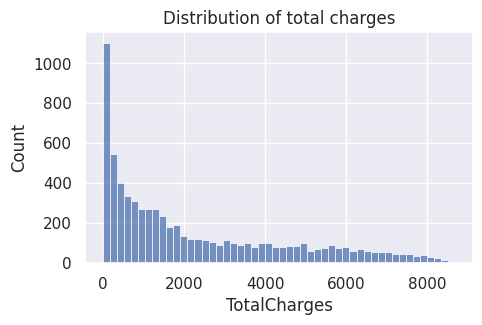

In [129]:
# Visualizing distribution of total charges
plt.figure(figsize = (5,3))
sns.histplot(df['TotalCharges'], bins = 50)
plt.title('Distribution of total charges')
plt.show()

As we can see on histograms:

* in tenure column a lot of values are placed at the begin and at the end of distribution
* the highest number of customers have smaller monthly charges
* with higher value of total charges decreases a number of customers who have it

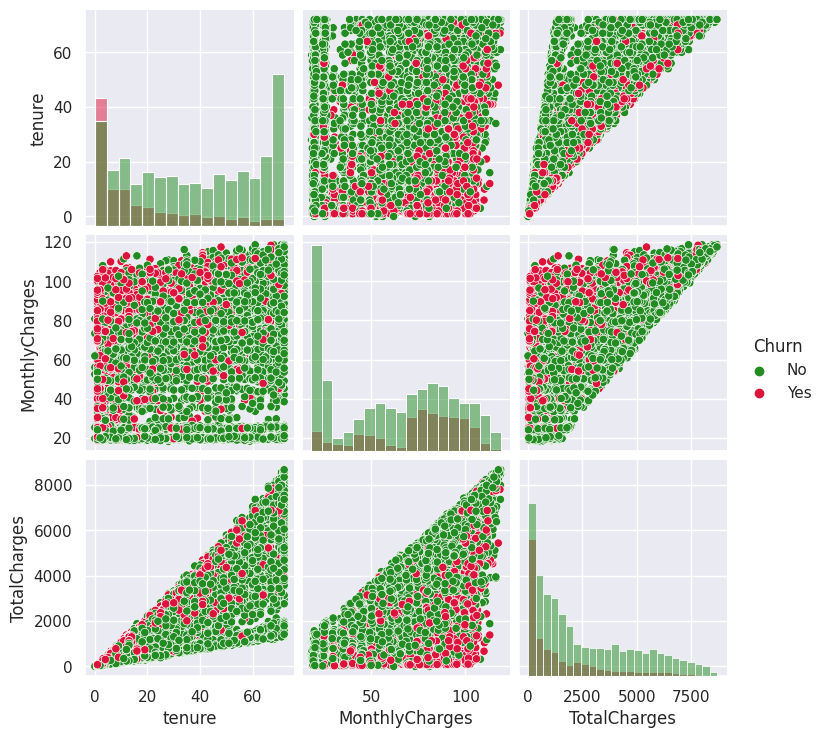

In [130]:
# Making pairplot with numerical data, include split by churn column
sns.pairplot(df, hue = 'Churn', palette = ['#228B22', '#DC143C'], diag_kind = 'hist')

The dataset has 3 numerical variables - tenure, MonthlyCharges and TotalCharges.

1. The first one indicates that the higher number of months a customer has stayed with the company is, the lower chance of this customer resignation.

2. The higher monthly charges, especially from range 75-100 increase risk of customer churn

3. In a chart between tenure and TotalCharges relationship, we can see smooth growth the TotalCharges, when the tenure increases.

4. Scatterplots show, that the dataset doesn't have outliers

In [131]:
# Making a scatterplot with relationship between tenure and
# totalcharges, split by InternetService
px.scatter(df,
           x = 'tenure',
           y = 'TotalCharges',
           color = 'InternetService',
           title = 'Tenure and TotalCharges relationship',
           trendline = 'ols',
           opacity = 0.3)


1. Fiber optic is the most expensive internet service.
2. Total Charges are the smallest when a customer doesn't have Internet Service.
3. Between no internet service and DSL is a quite significant space looking at TotalCharges

In [132]:
# Showing category variables statistics
df.describe(include = 'category')

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
count,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
unique,2,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4,2
top,Male,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,No
freq,3555,5901,3641,4933,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365,5174


<ipython-input-133-befa0283a3de>:13: UserWarning:

FixedFormatter should only be used together with FixedLocator

<ipython-input-133-befa0283a3de>:13: UserWarning:

FixedFormatter should only be used together with FixedLocator

<ipython-input-133-befa0283a3de>:13: UserWarning:

FixedFormatter should only be used together with FixedLocator



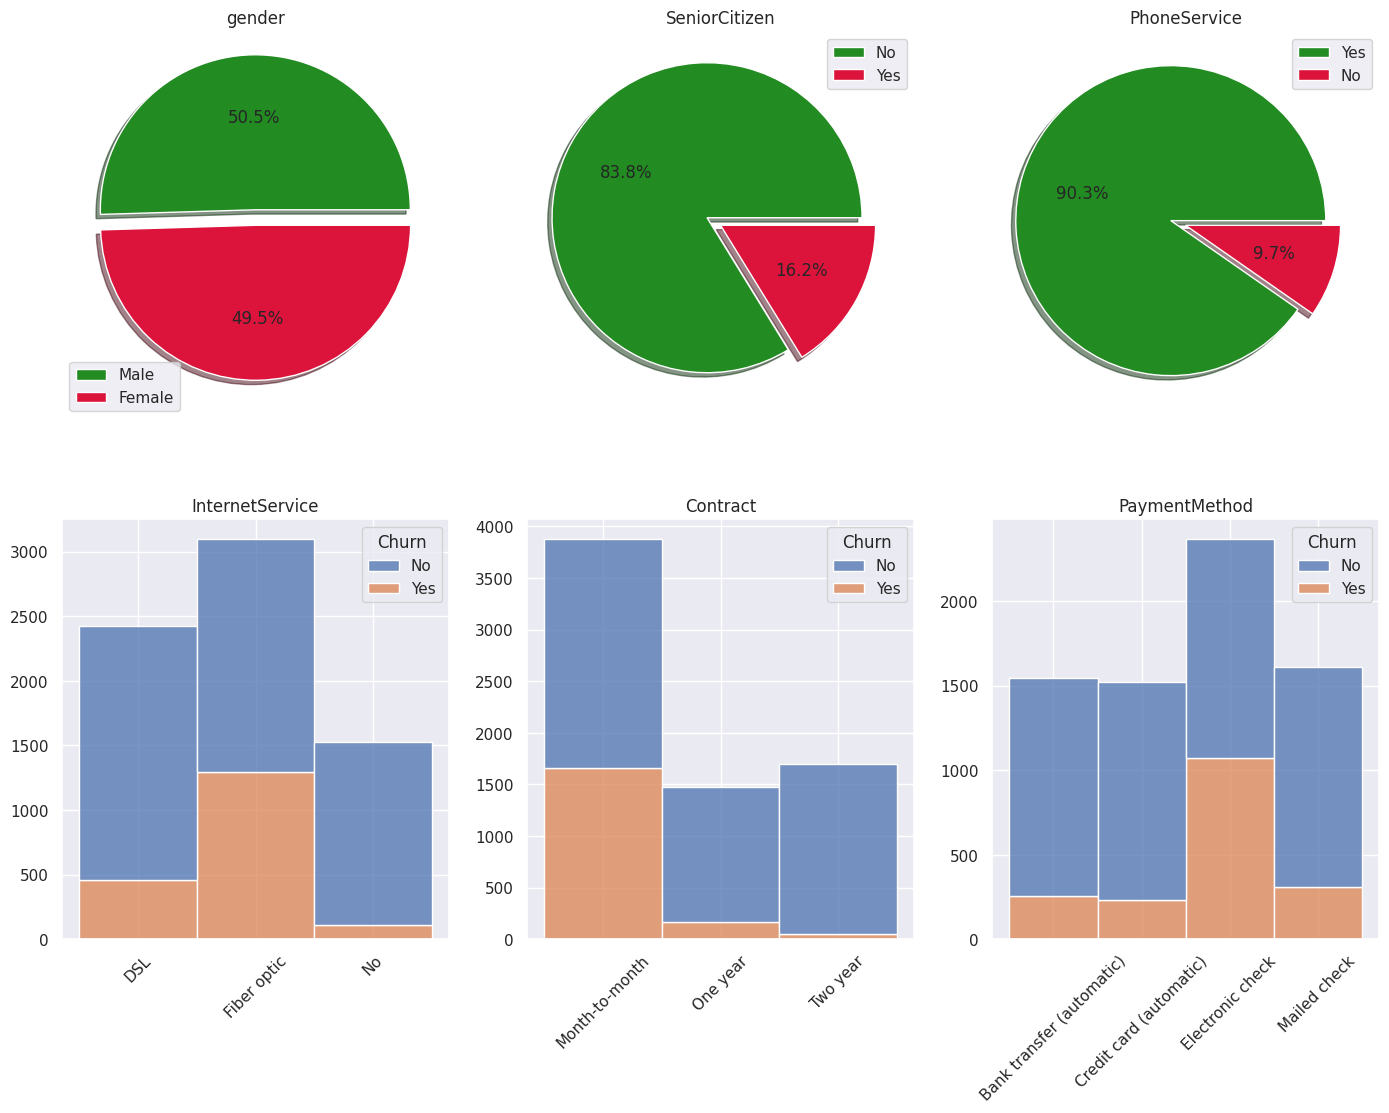

In [133]:
# Making plots for 6 interesting variables
fig, ax = plt.subplots(2,3, figsize = (17,12))
for index, col in enumerate(['gender', 'SeniorCitizen', 'PhoneService']):
  df[col].value_counts().plot(kind = 'pie', ax = ax[0,index], shadow = True,
                              title = col, colors = ['#228B22', '#DC143C'],
                              explode = [0.1, 0], autopct = '%1.1f%%',
                              labels = ['', ''], ylabel = '')
for index, col in enumerate(['InternetService', 'Contract', 'PaymentMethod']):
  sns.histplot(data = df, x = col, ax = ax[1, index], hue = 'Churn', multiple = 'stack')
  ax[1, index].title.set_text(col)
  ax[1, index].set_xlabel('')
  ax[1, index].set_ylabel('')
  ax[1, index].set_xticklabels(ax[1,index].get_xticklabels(), rotation = 45)

ax[0, 0].legend(['Male', 'Female'])
ax[0, 1].legend(['No', 'Yes'])
ax[0, 2].legend(['Yes', 'No'])
fig.show()

Above charts representing categorical variables distributions.

1. On the first graph is displayed a gender distribution. It is spread almost  equally with slightly prevalence for males.
2. There is 16% senior citizens in the dataset
3. 90 % of all customers in the dataset have purchased a phone service
4. The most popular internet service is Fiber optic. Number of customers who stayed with the company is aproximately between services. Unfortunately  the fiber optic, despite the most popularity has also a very high number of customers, who left the company
5. The most often customer's choice is contract month-to-month. In one year and two year contracts is very low number of churn
6. Electronic check is an outstanding factor in a payment method. Customers who pay, using this method make up the largest count in the dataset but nearly half of them resigned from the company

In [134]:
# Describing data when churn = 'Yes'
stats_churn_yes = df[df['Churn'] == 'Yes'].describe().T

# Describing data when churn = 'No'
stats_churn_no = df[df['Churn'] == 'No'].describe().T

# Creating dataframe with means include split by churn
mean_comparison_by_churn = pd.DataFrame({'mean_yes' : stats_churn_yes['mean'],
                                         'mean_no' : stats_churn_no['mean']})
mean_comparison_by_churn = mean_comparison_by_churn.T.reset_index(drop = True)
mean_comparison_by_churn['Churn'] = ['Yes', 'No']
mean_comparison_by_churn = round(mean_comparison_by_churn)
mean_comparison_by_churn

,tenure,MonthlyCharges,TotalCharges,Churn
0,18.0,74.0,1532.0,Yes
1,38.0,61.0,2550.0,No


In [135]:
# From above data, creating bar plots
fig = make_subplots(cols = 3,
                    subplot_titles = ('Average tenure',
                                      'Average monthly charges',
                                      'Average total charges'),
                    column_titles = ['Churn', 'Churn', 'Churn'])
fig.add_bar(x = mean_comparison_by_churn['Churn'],
            y = mean_comparison_by_churn['tenure'],
            row = 1,
            col = 1,
            name = 'tenure')
fig.add_bar(x = mean_comparison_by_churn['Churn'],
            y = mean_comparison_by_churn['MonthlyCharges'],
            row = 1,
            col = 2,
            name = 'MonthlyCharges')
fig.add_bar(x = mean_comparison_by_churn['Churn'],
            y = mean_comparison_by_churn['TotalCharges'],
            row = 1,
            col = 3,
            name = 'TotalCharges')
fig.layout.annotations[3].y = -0.15
fig.layout.annotations[4].y = -0.15
fig.layout.annotations[5].y = -0.15
fig.update_layout(title_text = 'Comparison of numerical columns averages in terms of churn',
                  title = {'x' : 0.5})
fig.show()

Charts depict comparison between means of numerical variables with data split by churn. Looking on these charts we can say:
1. Difference between customers who stayed with the company and those who resigned is tremendous (38 to 18 months).
2. Average monthly charges are higher for customers who left the company
3. Average total charges are higher for customers who stayed with company

In [136]:
# Showing statistics for category variables filtered by churn = 'Yes'
df[df['Churn'] == 'Yes'].describe(include = 'category')

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
count,1869,1869,1869,1869,1869,1869,1869,1869,1869,1869,1869,1869,1869,1869,1869,1869,1869
unique,2,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4,1
top,Female,0,No,No,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,Yes
freq,939,1393,1200,1543,1699,850,1297,1461,1233,1211,1446,942,938,1655,1400,1071,1869


In above statistics we can see that the 1200 of 1869 customers who resigned from the company, don't have a partner.

Similarly, data referring to the dependents column. Here is a very huge prevalence for customers who don't have dependets (1543 of 1869 customers).

It will be good idea to make plot with breakdown by these factors

In [137]:
# Histograms with count of churn, regarding if customers have partner and dependents
fig = px.histogram(df,
                   x = 'Churn',
                   facet_row = 'Partner',
                   facet_col = 'Dependents',
                   color = 'Churn',
                   text_auto = True)
fig.update_layout(font = {'size' : 16})

1. Looking on graphs it is clear to see that the most of customers don't have partner and dependents. In this case about 33% have resigned from the company.
2. The number of customers who don't have partner but have dependents is very interesting. It is equal only about 361 customers, when in the whole dataset are 7043 of them.
3. There is a slighty difference between number of customers who have a partner but don't have dependents (1653), compared to number of those who have a partner and dependents (1749). The higher difference will appear, when we consider additionally a split by churn. In the first case the churn = 'Yes' takes about 25% of these customers, whereas in the second group churn = 'Yes' takes only 14%

In [138]:
# Making a table which calculates an average of numerical variables grouped by
# partner and dependents
agg_df = df[['tenure', 'MonthlyCharges', 'TotalCharges',
             'Partner', 'Dependents']].groupby(['Partner', 'Dependents']).agg('mean')
round(agg_df)

tenure  MonthlyCharges  TotalCharges
Partner Dependents                                      
No      No            23.0            63.0        1611.0
        Yes           24.0            53.0        1342.0
Yes     No            43.0            75.0        3333.0
        Yes           41.0            61.0        2733.0

It is a table with averages of numerical variables grouped by partner and dependents.

In this table can we see that the customers who have a partner are marked by longer time in the company. Also their monthly charges and total charges are higher than those with no partner.

Average monthly and total charges in relation to dependents are higher, where customers don't have dependents.






# Adding columns, converting categorical data, splitting dataset, standarizing numerical data

In [139]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [140]:
# Add a new column with ranges of tenure
df['tenure_cats'] = pd.cut(df['tenure'],
                           bins = [-1,2,70,73],
                           labels = ['0-2', '3-70', '71-72'])

In [141]:
# Add a new column with ranges of monthly charges
df['MonthlyCharges_cats'] = pd.cut(df['MonthlyCharges'],
                                   bins = [-1, 30, 150],
                                   labels = ['0-30', '30+'])

In [142]:
# Getting dummies
df_dummies = pd.get_dummies(df,
                            columns = [col
                                       for col in df.columns
                                       if col not in ['tenure',	'MonthlyCharges',
                                                      'TotalCharges', 'Churn']],
                            drop_first = True)

# Converting target values to binary
le = LabelEncoder()
df_dummies['Churn'] = le.fit_transform(df_dummies['Churn'])

df_dummies.head(3)

,tenure,MonthlyCharges,TotalCharges,Churn,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure_cats_3-70,tenure_cats_71-72,MonthlyCharges_cats_30+
0,1,29.85,29.85,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
1,34,56.95,1889.50,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,1,0,1
2,2,53.85,108.15,1,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1


In [143]:
# Splitting data to data and target
data = df_dummies.copy()
target = data.pop('Churn')
data.head()

,tenure,MonthlyCharges,TotalCharges,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure_cats_3-70,tenure_cats_71-72,MonthlyCharges_cats_30+
0,1,29.85,29.85,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
1,34,56.95,1889.50,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,1,0,1
2,2,53.85,108.15,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1
3,45,42.30,1840.75,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1
4,2,70.70,151.65,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1


In [144]:
target.head()

0    0
1    0
2    1
3    0
4    1
Name: Churn, dtype: int64

In [145]:
# Splitting the data and target on train and test sets
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = 0.2, stratify = target)


print('Shape of X_train:', X_train.shape)
print('Shape of y_train:', y_train.shape)
print('Shape of X_test:', X_test.shape)
print('Shape of y_test:', y_test.shape)
print(f'\nDistribution of y_train:\n{y_train.value_counts()}\n')
print(f'Distribution of y_test:\n{y_test.value_counts()}')

Shape of X_train: (5634, 33)
Shape of y_train: (5634,)
Shape of X_test: (1409, 33)
Shape of y_test: (1409,)

Distribution of y_train:
0    4139
1    1495
Name: Churn, dtype: int64

Distribution of y_test:
0    1035
1     374
Name: Churn, dtype: int64


In [146]:
X_train.head()

,tenure,MonthlyCharges,TotalCharges,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure_cats_3-70,tenure_cats_71-72,MonthlyCharges_cats_30+
3738,35,49.20,1701.65,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,1,0,1
3151,15,75.10,1151.55,1,0,1,1,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1
4860,13,40.55,590.35,1,0,1,1,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,1
3867,26,73.50,1905.70,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,1,1,1,0,0,1,0,1
3810,1,44.55,44.55,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1


In [147]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5634 entries, 3738 to 5639
Data columns (total 33 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   tenure                                 5634 non-null   int64  
 1   MonthlyCharges                         5634 non-null   float64
 2   TotalCharges                           5634 non-null   float64
 3   gender_Male                            5634 non-null   uint8  
 4   SeniorCitizen_1                        5634 non-null   uint8  
 5   Partner_Yes                            5634 non-null   uint8  
 6   Dependents_Yes                         5634 non-null   uint8  
 7   PhoneService_Yes                       5634 non-null   uint8  
 8   MultipleLines_No phone service         5634 non-null   uint8  
 9   MultipleLines_Yes                      5634 non-null   uint8  
 10  InternetService_Fiber optic            5634 non-null   uint8  
 11  I

In [148]:
# Standarizing numerical data to mean = 0 and variance = 1
scaler = StandardScaler()
X_train[['tenure', 'MonthlyCharges', 'TotalCharges']] = scaler.fit_transform(X_train[['tenure', 'MonthlyCharges', 'TotalCharges']])

X_test[['tenure', 'MonthlyCharges', 'TotalCharges']] = scaler.transform(X_test[['tenure', 'MonthlyCharges', 'TotalCharges']])


X_train_means = [round(X_train[col].mean(), 3) for col in ['tenure', 'MonthlyCharges', 'TotalCharges']]
X_test_means = [round(X_test[col].mean(), 3) for col in ['tenure', 'MonthlyCharges', 'TotalCharges']]
X_train_variance = [round((X_train[col].std())**2, 3) for col in ['tenure', 'MonthlyCharges', 'TotalCharges']]
X_test_variance = [round((X_test[col].std())**2, 3) for col in ['tenure', 'MonthlyCharges', 'TotalCharges']]

print('Means for X_train numerical columns:', X_train_means)
print('Means for X_test numerical columns:', X_test_means)
print('Variances for X_train numerical columns:', X_train_variance)
print('Variances for X_test numerical columns:', X_test_variance)

Means for X_train numerical columns: [-0.0, -0.0, 0.0]
Means for X_test numerical columns: [-0.023, -0.028, -0.043]
Variances for X_train numerical columns: [1.0, 1.0, 1.0]
Variances for X_test numerical columns: [0.997, 0.984, 0.945]


# Selecting features

In [149]:
# Selecting features based on the Random forest classifier's property "feature_importances_"

classifier = RandomForestClassifier(500, random_state = 42, class_weight = 'balanced')
classifier.fit(X_train, y_train)

importances = classifier.feature_importances_
df_rf_importance = pd.DataFrame({'feat' : list(X_train.columns),
                                 'importance' : list(importances)})

df_rf_importance = df_rf_importance.sort_values('importance', ascending = False)
df_rf_importance = df_rf_importance.reset_index(drop = True)
df_rf_importance

,feat,importance
0,TotalCharges,0.171219
1,tenure,0.155541
2,MonthlyCharges,0.145334
3,Contract_Two year,0.053912
4,InternetService_Fiber optic,0.044062
5,PaymentMethod_Electronic check,0.038558
6,Contract_One year,0.028342
7,OnlineSecurity_Yes,0.025989
8,gender_Male,0.025831
9,TechSupport_Yes,0.024922


As we can see on above table, columns with "No internet service" and "phone service" often are less significant than other columns.

The most significant columns in the dataset for this type of feature selection are numerical columns (TotalCharges, tenure, MonthlyCharges).

Below we will make simulation how numer of features influence on working models (for example Random forest classifier and Logistic Regression)

In [150]:
# Plotting relationship between number of features and metrics: f1 score, AUC,
# balanced_accuracy
# Creating a dataframe with number of features and corresponding to each values of
# metrics (AUC, f1 score, balanced_accuracy, precision, recall)
def feats_selection_comparison(X_train, X_test, y_train, y_test, ordered_columns, classifier = RandomForestClassifier()):
  df = pd.DataFrame(columns = ['k', 'AUC', 'f1', 'bal_acc', 'precision', 'recall'])
  for k in range(1, len(ordered_columns) + 1):
    X_train_k = X_train[ordered_columns[:k]]
    X_test_k = X_test[ordered_columns[:k]]

    classifier = classifier
    classifier.fit(X_train_k, y_train)

    y_pred = classifier.predict(X_test_k)

    acc = round(balanced_accuracy_score(y_test, y_pred), 3)
    auc = round(roc_auc_score(y_test, y_pred), 3)
    f1 = round(f1_score(y_test, y_pred), 3)
    precision = round(precision_score(y_test, y_pred, zero_division=0), 3)
    recall = round(recall_score(y_test, y_pred), 3)

    df.loc[len(df)] = [k, auc, f1, acc, precision, recall]

  plt.figure(figsize = (7,5))
  sns.lineplot(df, x = 'k', y = 'f1', label = 'f1')
  sns.lineplot(df, x = 'k', y = 'bal_acc', label = 'bal_acc')
  plt.show()

  return df.T

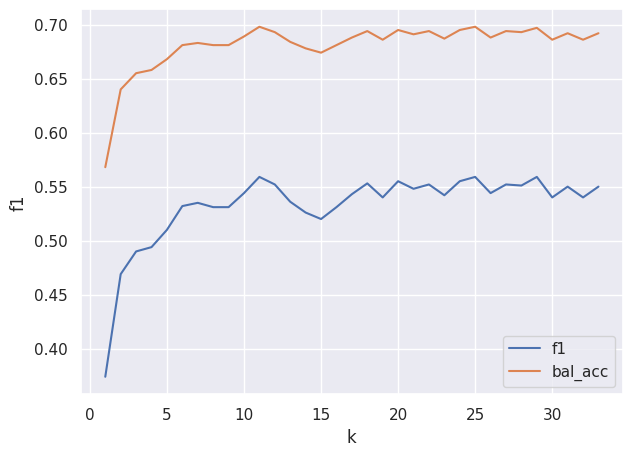

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32
k,1.000,2.000,3.000,4.000,5.000,6.000,7.000,8.000,9.000,10.000,11.000,12.000,13.000,14.000,15.000,16.000,17.000,18.000,19.000,20.000,21.000,22.000,23.000,24.000,25.000,26.000,27.000,28.000,29.000,30.000,31.000,32.000,33.000
AUC,0.568,0.640,0.655,0.658,0.668,0.681,0.683,0.681,0.681,0.689,0.698,0.693,0.684,0.678,0.674,0.681,0.688,0.694,0.686,0.695,0.691,0.694,0.687,0.695,0.698,0.688,0.694,0.693,0.697,0.686,0.692,0.686,0.692
f1,0.374,0.469,0.490,0.494,0.510,0.532,0.535,0.531,0.531,0.544,0.559,0.552,0.536,0.526,0.520,0.531,0.543,0.553,0.540,0.555,0.548,0.552,0.542,0.555,0.559,0.544,0.552,0.551,0.559,0.540,0.550,0.540,0.550
bal_acc,0.568,0.640,0.655,0.658,0.668,0.681,0.683,0.681,0.681,0.689,0.698,0.693,0.684,0.678,0.674,0.681,0.688,0.694,0.686,0.695,0.691,0.694,0.687,0.695,0.698,0.688,0.694,0.693,0.697,0.686,0.692,0.686,0.692
precision,0.356,0.482,0.538,0.538,0.553,0.579,0.565,0.559,0.569,0.585,0.606,0.615,0.622,0.623,0.623,0.639,0.642,0.635,0.625,0.631,0.633,0.639,0.629,0.640,0.642,0.633,0.639,0.626,0.637,0.625,0.632,0.625,0.637
recall,0.393,0.457,0.449,0.457,0.473,0.492,0.508,0.505,0.497,0.508,0.519,0.500,0.471,0.455,0.447,0.455,0.471,0.489,0.476,0.495,0.484,0.487,0.476,0.489,0.495,0.476,0.487,0.492,0.497,0.476,0.487,0.476,0.484


In [151]:
feats_selection_comparison(X_train, X_test, y_train, y_test,
                           list(df_rf_importance['feat']),
                           classifier = RandomForestClassifier(500,
                                                               random_state = 42,
                                                               class_weight = 'balanced'))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



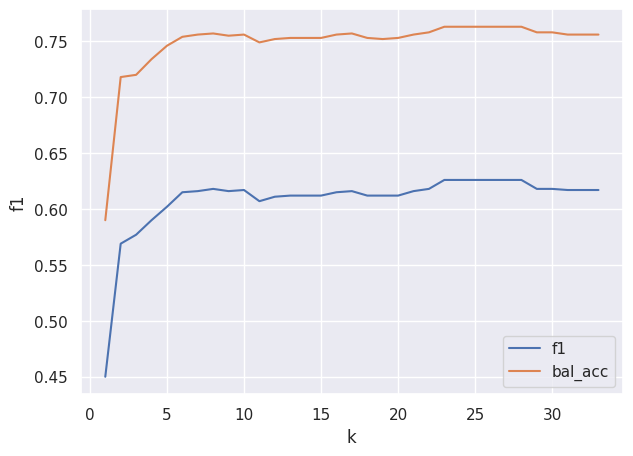

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32
k,1.000,2.000,3.000,4.000,5.000,6.000,7.000,8.000,9.000,10.000,11.000,12.000,13.000,14.000,15.000,16.000,17.000,18.000,19.000,20.000,21.000,22.000,23.000,24.000,25.000,26.000,27.000,28.000,29.000,30.000,31.000,32.000,33.000
AUC,0.590,0.718,0.720,0.734,0.746,0.754,0.756,0.757,0.755,0.756,0.749,0.752,0.753,0.753,0.753,0.756,0.757,0.753,0.752,0.753,0.756,0.758,0.763,0.763,0.763,0.763,0.763,0.763,0.758,0.758,0.756,0.756,0.756
f1,0.450,0.569,0.577,0.590,0.602,0.615,0.616,0.618,0.616,0.617,0.607,0.611,0.612,0.612,0.612,0.615,0.616,0.612,0.612,0.612,0.616,0.618,0.626,0.626,0.626,0.626,0.626,0.626,0.618,0.618,0.617,0.617,0.617
bal_acc,0.590,0.718,0.720,0.734,0.746,0.754,0.756,0.757,0.755,0.756,0.749,0.752,0.753,0.753,0.753,0.756,0.757,0.753,0.752,0.753,0.756,0.758,0.763,0.763,0.763,0.763,0.763,0.763,0.758,0.758,0.756,0.756,0.756
precision,0.323,0.438,0.478,0.475,0.482,0.503,0.503,0.507,0.504,0.505,0.492,0.495,0.494,0.494,0.495,0.497,0.498,0.498,0.498,0.498,0.502,0.502,0.516,0.516,0.516,0.516,0.516,0.516,0.504,0.504,0.503,0.503,0.503
recall,0.743,0.813,0.727,0.778,0.802,0.791,0.794,0.791,0.791,0.791,0.794,0.799,0.802,0.802,0.802,0.807,0.807,0.794,0.791,0.794,0.799,0.805,0.797,0.797,0.797,0.797,0.797,0.797,0.799,0.799,0.797,0.797,0.797


In [152]:
feats_selection_comparison(X_train, X_test, y_train, y_test,
                           list(df_rf_importance['feat']),
                           classifier = LogisticRegression(random_state = 42, class_weight = 'balanced'))

Looking at created plots and tables we can see that the best results we will receive, when we select first 25 features. In the next step we will drop unnecesary columns.

In [153]:
X_train = X_train[list(df_rf_importance['feat'])[:25]]
X_test = X_test[list(df_rf_importance['feat'])[:25]]
X_train.head(3)

,TotalCharges,tenure,MonthlyCharges,Contract_Two year,InternetService_Fiber optic,PaymentMethod_Electronic check,Contract_One year,OnlineSecurity_Yes,gender_Male,TechSupport_Yes,PaperlessBilling_Yes,Partner_Yes,OnlineBackup_Yes,Dependents_Yes,MultipleLines_Yes,SeniorCitizen_1,DeviceProtection_Yes,StreamingMovies_Yes,StreamingTV_Yes,PaymentMethod_Credit card (automatic),tenure_cats_3-70,PaymentMethod_Mailed check,StreamingTV_No internet service,DeviceProtection_No internet service,OnlineSecurity_No internet service
3738,-0.262257,0.102371,-0.521976,0,0,1,0,0,1,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,0
3151,-0.503635,-0.711743,0.337478,0,1,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0
4860,-0.749883,-0.793155,-0.809013,1,0,0,0,1,1,1,0,1,1,1,0,0,0,0,0,0,1,1,0,0,0


<Axes: >

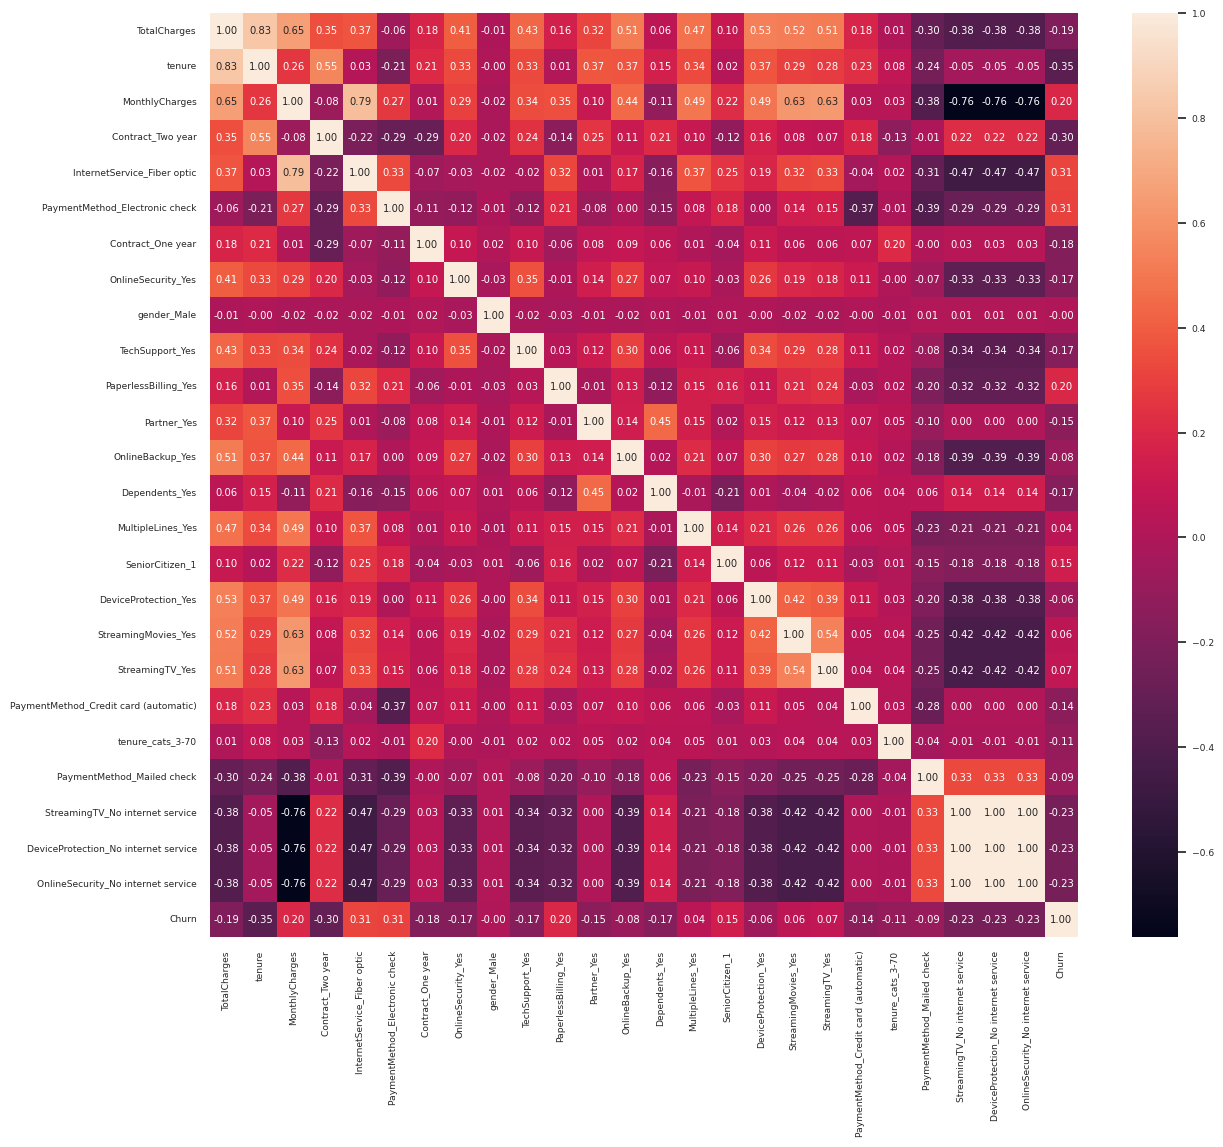

In [154]:
# Creating correlation matrix
corr_matrix = pd.concat([X_train.reset_index(drop = True),
                         y_train.reset_index(drop = True)], axis = 1).corr()
sns.set_theme(font_scale = 0.6)
plt.figure(figsize = (14,12))
sns.heatmap(corr_matrix, annot = True, fmt = '.2f')

On heat map it's clear to see, that the 3 variables are in 100% correlated each with each.
Columns gender_Male and MultipleLine_Yes are very low correlated with target.
These columns have to be removed

In [155]:
print('X_train shape before:', X_train.shape)
print('X_test shape before:', X_test.shape)

# Dropping useless columns
X_train = X_train.drop(columns = [col for col in X_train.columns[-2:]] + ['gender_Male', 'MultipleLines_Yes'])
X_test = X_test.drop(columns = [col for col in X_test.columns[-2:]] + ['gender_Male', 'MultipleLines_Yes'])

print('\nX_train shape after:', X_train.shape)
print('X_test shape after:', X_test.shape)

X_train shape before: (5634, 25)
X_test shape before: (1409, 25)

X_train shape after: (5634, 21)
X_test shape after: (1409, 21)


In [156]:
X_test.head()

,TotalCharges,tenure,MonthlyCharges,Contract_Two year,InternetService_Fiber optic,PaymentMethod_Electronic check,Contract_One year,OnlineSecurity_Yes,TechSupport_Yes,PaperlessBilling_Yes,Partner_Yes,OnlineBackup_Yes,Dependents_Yes,SeniorCitizen_1,DeviceProtection_Yes,StreamingMovies_Yes,StreamingTV_Yes,PaymentMethod_Credit card (automatic),tenure_cats_3-70,PaymentMethod_Mailed check,StreamingTV_No internet service
437,2.706828,1.608483,1.629976,1,1,0,0,1,1,1,1,1,1,0,1,1,1,1,0,0,0
2280,-0.610260,-0.996684,1.168725,0,1,0,0,0,1,1,0,0,0,1,0,1,1,1,1,0,0
2235,0.400116,0.346606,0.445324,0,0,0,1,1,0,1,1,1,1,0,1,0,1,1,1,0,0
4460,-0.364451,-0.589626,0.440347,0,1,1,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0
3761,1.588421,1.608483,0.588013,1,0,0,0,1,0,1,1,1,0,0,1,1,1,1,0,0,0


The dataset is now ready for training.

In this dataset larger importance should have targets when Churn = Yes. The reason is that the company wants to know when a customer  will actually want to leave the company, even if it will be caused more incorrect predictions for target "true No".

Due to these factors, fbeta-score will be an appropriate metric for learning. Parameter beta will be set to 2, because more important for us is recall than precision

# Model training

In [157]:
# Creating a function to making dataframe from cv_results. In default option dataframe
# is sorted by the best rank test score and mean fit time.
# The function display top 5 rows
def make_cv_results_df(classifier, sort_by = ['rank_test_score', 'mean_fit_time'], head = 5):
  cv_results_df = pd.DataFrame(classifier.cv_results_)[['mean_fit_time',
                                                        'params',
                                                        'mean_test_score',
                                                        'std_test_score',
                                                        'rank_test_score',
                                                        'mean_train_score',
                                                        'std_train_score']]
  cv_results_df = cv_results_df.sort_values(sort_by).head(head)
  return cv_results_df

In [158]:
# This is a function which converting params from cv_results_df to be ready
# for next training. For numerical parameters are added more values which could
# improve the model
def create_improved_params(cv_results_df):
  params = []
  for dictionary in cv_results_df['params']:

    params_dict = {}
    for key in list(dictionary.keys()):

      if key == 'C':
        params_dict[key] = [round(dictionary[key] * value, 3)
                            for value in np.arange(0.96, 1.04, 0.01)]

      elif key == 'n_neighbors':
        params_dict[key] = [dictionary[key] + (value - 2)
                            for value in np.arange(0, 4, 1)]

      elif key == 'gamma':
        params_dict[key] = np.unique([round(dictionary[key] * value, 3)
                                      for value in np.arange(0.96, 1.05, 0.02)])

      elif key == 'n_estimators':
        params_dict[key] = [int(dictionary[key] * value)
                            for value in np.arange(0.9, 1.1, 0.05)]

      elif key == 'max_depth':
        params_dict[key] = [dictionary[key] + (value - 1)
                            for value in np.arange(0,2,1)]

      else:
        params_dict[key] = [dictionary[key]]
    params.append(params_dict)

  return params

## Logistic Regression

In [159]:
# Making f score metric with beta = 2
scoring = make_scorer(fbeta_score, beta = 2)

# Display more of informations in cv_results_df
pd.set_option('display.max_colwidth', 150)

In [160]:
# Looking for the best parameters for logistic regression
estimator = LogisticRegression()

params = {
    'C' : [num for num in (np.arange(0.25, 15.1, 0.5) + [1])],
    'solver' : ['lbfgs', 'newton-cg', 'newton-cholesky'],
    'class_weight' : ['balanced'],
    'random_state' : [42]
}

log_reg_classifier = GridSearchCV(estimator,
                                  params,
                                  scoring = scoring,
                                  cv = 10,
                                  return_train_score = True)

log_reg_classifier.fit(X_train, y_train)

log_reg_mean_score = log_reg_classifier.best_score_
log_reg_X_test_score = log_reg_classifier.score(X_test, y_test)

print(f'Best mean test score: {log_reg_classifier.best_score_}')
print(f'X_test score is equal: {log_reg_X_test_score}')
print(f'The best params: {log_reg_classifier.best_params_}')

Best mean test score: 0.7261752989491013
X_test score is equal: 0.7256126862085536
The best params: {'C': 1.75, 'class_weight': 'balanced', 'random_state': 42, 'solver': 'lbfgs'}


In [161]:
# Showing cv_results
log_reg_cv_results_df = make_cv_results_df(log_reg_classifier)
log_reg_cv_results_df

,mean_fit_time,params,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
8,0.018513,"{'C': 2.25, 'class_weight': 'balanced', 'random_state': 42, 'solver': 'newton-cholesky'}",0.726175,0.020211,1,0.729266,0.002565
5,0.019538,"{'C': 1.75, 'class_weight': 'balanced', 'random_state': 42, 'solver': 'newton-cholesky'}",0.726175,0.020211,1,0.729209,0.002590
11,0.021487,"{'C': 2.75, 'class_weight': 'balanced', 'random_state': 42, 'solver': 'newton-cholesky'}",0.726175,0.020211,1,0.729256,0.002619
9,0.044945,"{'C': 2.75, 'class_weight': 'balanced', 'random_state': 42, 'solver': 'lbfgs'}",0.726175,0.020211,1,0.729266,0.002619
3,0.046583,"{'C': 1.75, 'class_weight': 'balanced', 'random_state': 42, 'solver': 'lbfgs'}",0.726175,0.020211,1,0.729170,0.002572


In [162]:
# Choosing the best params, measuring time of execution and creating various metrics
estimator = LogisticRegression()

best_params = log_reg_cv_results_df.values[0][1]
params = {key : [best_params[key]] for key in list(best_params)}

log_reg_classifier = GridSearchCV(estimator,
                                  params,
                                  scoring = scoring,
                                  cv = 10,
                                  return_train_score = True)
start = time.time()
log_reg_classifier.fit(X_train, y_train)
end = time.time()

log_reg_time = end - start
log_reg_mean_score = log_reg_classifier.best_score_
log_reg_X_test_score = log_reg_classifier.score(X_test, y_test)
log_reg_balanced_accuracy = balanced_accuracy_score(y_test, log_reg_classifier.predict(X_test))
log_reg_auc = roc_auc_score(y_test, log_reg_classifier.predict(X_test))
log_reg_recall = recall_score(y_test, log_reg_classifier.predict(X_test))

print(f'Best mean test score: {log_reg_classifier.best_score_}')
print(f'X_test score is equal: {log_reg_X_test_score}')
print(f'The best params: {log_reg_classifier.best_params_}')

Best mean test score: 0.7261752989491013
X_test score is equal: 0.7256126862085536
The best params: {'C': 2.25, 'class_weight': 'balanced', 'random_state': 42, 'solver': 'newton-cholesky'}


## Linear SVC

In [163]:
# Looking for the best parameters for linear SVC
estimator = LinearSVC()

params = {
    'C' : [num for num in (np.arange(0.25, 15.1, 0.5) + [1])],
    'loss' : ['hinge', 'squared_hinge'],
    'class_weight' : ['balanced'],
    'random_state' : [42]
}
lin_SVC_classifier = GridSearchCV(estimator = estimator,
                                  param_grid = params,
                                  scoring = scoring,
                                  cv = 10,
                                  n_jobs = -1,
                                  return_train_score = True)
lin_SVC_classifier.fit(X_train, y_train)

lin_SVC_mean_score = lin_SVC_classifier.best_score_
lin_SVC_X_test_score = lin_SVC_classifier.score(X_test, y_test)

print(f'Best mean test score: {lin_SVC_mean_score}')
print(f'X_test score is equal: {lin_SVC_X_test_score}')
print(f'The best params: {lin_SVC_classifier.best_params_}')

Best mean test score: 0.7277032057204663
X_test score is equal: 0.7059679767103348
The best params: {'C': 9.75, 'class_weight': 'balanced', 'loss': 'squared_hinge', 'random_state': 42}


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



In [164]:
# Showing cv_results
lin_SVC_cv_results_df = make_cv_results_df(lin_SVC_classifier)
lin_SVC_cv_results_df

,mean_fit_time,params,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
35,0.602356,"{'C': 9.75, 'class_weight': 'balanced', 'loss': 'squared_hinge', 'random_state': 42}",0.727703,0.021967,1,0.728668,0.004791
25,0.595318,"{'C': 7.25, 'class_weight': 'balanced', 'loss': 'squared_hinge', 'random_state': 42}",0.724497,0.022586,2,0.730918,0.003380
27,0.597288,"{'C': 7.75, 'class_weight': 'balanced', 'loss': 'squared_hinge', 'random_state': 42}",0.723512,0.024209,3,0.730586,0.003999
15,0.960348,"{'C': 4.75, 'class_weight': 'balanced', 'loss': 'squared_hinge', 'random_state': 42}",0.723426,0.023756,4,0.731299,0.003471
1,0.581139,"{'C': 1.25, 'class_weight': 'balanced', 'loss': 'squared_hinge', 'random_state': 42}",0.723083,0.022961,5,0.731266,0.003445


In [165]:
# Choosing the best params, measuring time of execution and creating various metrics

estimator = LinearSVC()

best_params = lin_SVC_cv_results_df.values[0][1]
params = {key : [best_params[key]] for key in list(best_params)}

lin_SVC_classifier = GridSearchCV(estimator = estimator,
                                  param_grid = params,
                                  scoring = scoring,
                                  cv = 10,
                                  n_jobs = -1,
                                  return_train_score = True)

start = time.time()
lin_SVC_classifier.fit(X_train, y_train)
end = time.time()

lin_SVC_time = end - start
lin_SVC_mean_score = lin_SVC_classifier.best_score_
lin_SVC_X_test_score = lin_SVC_classifier.score(X_test, y_test)
lin_SVC_balanced_accuracy = balanced_accuracy_score(y_test, lin_SVC_classifier.predict(X_test))
lin_SVC_auc = roc_auc_score(y_test, lin_SVC_classifier.predict(X_test))
lin_SVC_recall = recall_score(y_test, lin_SVC_classifier.predict(X_test))

print(f'Best mean test score: {lin_SVC_mean_score}')
print(f'X_test score is equal: {lin_SVC_X_test_score}')
print(f'The best params: {lin_SVC_classifier.best_params_}')

Best mean test score: 0.7277032057204663
X_test score is equal: 0.7059679767103348
The best params: {'C': 9.75, 'class_weight': 'balanced', 'loss': 'squared_hinge', 'random_state': 42}


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



## k Neighbors Classifier

In [166]:
# Searching the best paremeters for kNearest Neighbors classifier
estimator = KNeighborsClassifier()

params = {
    'n_neighbors' : [3, 5, 7, 10, 15, 25, 40, 100],
    'weights' : ['uniform', 'distance'],
    'p' : [1,2]
}
kNN_classifier = GridSearchCV(estimator = estimator,
                          param_grid = params,
                          scoring = scoring,
                          cv = 10,
                          n_jobs = -1,
                          return_train_score = True)
kNN_classifier.fit(X_train, y_train)

kNN_mean_score = kNN_classifier.best_score_
kNN_X_test_score = kNN_classifier.score(X_test, y_test)

print(f'Best mean test score: {kNN_mean_score}')
print(f'The best score is equal: {kNN_X_test_score}')
print(f'The best params: {kNN_classifier.best_params_}')

Best mean test score: 0.5788736388122626
The best score is equal: 0.5704148471615721
The best params: {'n_neighbors': 100, 'p': 1, 'weights': 'uniform'}


In [167]:
# Showing cv_results
kNN_cv_results_df = make_cv_results_df(kNN_classifier)
kNN_cv_results_df

,mean_fit_time,params,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
28,0.006402,"{'n_neighbors': 100, 'p': 1, 'weights': 'uniform'}",0.578874,0.030887,1,0.581648,0.008941
30,0.009481,"{'n_neighbors': 100, 'p': 2, 'weights': 'uniform'}",0.571418,0.033586,2,0.574235,0.008524
29,0.006802,"{'n_neighbors': 100, 'p': 1, 'weights': 'distance'}",0.568318,0.030395,3,0.994211,0.000528
31,0.008469,"{'n_neighbors': 100, 'p': 2, 'weights': 'distance'}",0.563976,0.037753,4,0.994211,0.000528
20,0.006855,"{'n_neighbors': 25, 'p': 1, 'weights': 'uniform'}",0.553908,0.021447,5,0.593840,0.007971


In [168]:
# Choosing the best params, measuring time of execution and creating various metrics

estimator = KNeighborsClassifier()

best_params = kNN_cv_results_df.values[0][1]
params = {key : [best_params[key]] for key in list(best_params)}

kNN_classifier = GridSearchCV(estimator = estimator,
                          param_grid = params,
                          scoring = scoring,
                          cv = 10,
                          n_jobs = -1,
                          return_train_score = True)

start = time.time()
kNN_classifier.fit(X_train, y_train)
end = time.time()

kNN_time = end - start
kNN_mean_score = kNN_classifier.best_score_
kNN_X_test_score = kNN_classifier.score(X_test, y_test)
kNN_balanced_accuracy = balanced_accuracy_score(y_test, kNN_classifier.predict(X_test))
kNN_auc = roc_auc_score(y_test, kNN_classifier.predict(X_test))
kNN_recall = recall_score(y_test, kNN_classifier.predict(X_test))

print(f'Best mean test score: {kNN_mean_score}')
print(f'The best score is equal: {kNN_X_test_score}')
print(f'The best params: {kNN_classifier.best_params_}')

Best mean test score: 0.5788736388122626
The best score is equal: 0.5704148471615721
The best params: {'n_neighbors': 100, 'p': 1, 'weights': 'uniform'}


## SVC

In [169]:
# Searching the best paremeters for SVC classifier using randomized search CV
estimator = SVC()

params = [{'C' : [num for num in np.arange(0.5, 15.1, 0.5)],
           'kernel' : ['linear', 'sigmoid'],
           'class_weight' : ['balanced'],
           'random_state' : [42]},
          {'C' : [num for num in np.arange(0.5, 15.1, 0.5)],
           'kernel' : ['rbf'],
           'gamma' : [num for num in np.arange(0.005, 0.101, 0.005)],
           'class_weight' : ['balanced'],
           'random_state' : [42]},
          {'C' : [num for num in np.arange(0.5, 15.1, 0.5)],
           'kernel' : ['poly'],
           'degree' : [2,3,4],
           'class_weight' : ['balanced'],
           'random_state' : [42]}]

SVC_classifier = RandomizedSearchCV(estimator,
                                    params,
                                    scoring = scoring,
                                    n_iter = 50,
                                    cv = 10,
                                    n_jobs = -1,
                                    return_train_score = True)
SVC_classifier.fit(X_train, y_train)

SVC_mean_score = SVC_classifier.best_score_
SVC_X_test_score = SVC_classifier.score(X_test, y_test)

print(f'Best mean test score: {SVC_mean_score}')
print(f'X_test score is equal: {SVC_X_test_score}')
print(f'The best params: {SVC_classifier.best_params_}')

Best mean test score: 0.7254521139770193
X_test score is equal: 0.7149735194992778
The best params: {'random_state': 42, 'kernel': 'rbf', 'gamma': 0.025, 'class_weight': 'balanced', 'C': 13.5}


In [170]:
# Making a cv_results_df
SVC_cv_results_df = make_cv_results_df(SVC_classifier)
SVC_cv_results_df

,mean_fit_time,params,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
16,2.628769,"{'random_state': 42, 'kernel': 'rbf', 'gamma': 0.025, 'class_weight': 'balanced', 'C': 13.5}",0.725452,0.018594,1,0.738690,0.005334
30,2.608368,"{'random_state': 42, 'kernel': 'rbf', 'gamma': 0.034999999999999996, 'class_weight': 'balanced', 'C': 14.5}",0.724715,0.017402,2,0.752364,0.002601
31,2.024272,"{'random_state': 42, 'kernel': 'rbf', 'gamma': 0.04, 'class_weight': 'balanced', 'C': 1.0}",0.724522,0.022049,3,0.730842,0.004345
38,2.259528,"{'random_state': 42, 'kernel': 'rbf', 'gamma': 0.015, 'class_weight': 'balanced', 'C': 14.0}",0.724275,0.019505,4,0.731997,0.005369
14,2.388787,"{'random_state': 42, 'kernel': 'rbf', 'gamma': 0.025, 'class_weight': 'balanced', 'C': 10.5}",0.723768,0.018948,5,0.737104,0.005778


In [171]:
# Creating params from the best one cv_result
params = create_improved_params(SVC_cv_results_df.head(1))
params

[{'random_state': [42],
  'kernel': ['rbf'],
  'gamma': array([0.024, 0.025, 0.026]),
  'class_weight': ['balanced'],
  'C': [12.96, 13.095, 13.23, 13.365, 13.5, 13.635, 13.77, 13.905, 14.04]}]

In [172]:
# Using gridSearch finding the best one option from selected parameters
SVC_classifier = GridSearchCV(estimator,
                              params,
                              scoring = scoring,
                              cv = 10,
                              n_jobs = -1,
                              verbose = 1,
                              return_train_score = True)
SVC_classifier.fit(X_train, y_train)

SVC_mean_score = SVC_classifier.best_score_
SVC_score = SVC_classifier.score(X_test, y_test)

print(f'Best mean test score: {SVC_mean_score}')
print(f'X_test score is equal: {SVC_score}')
print(f'The best params: {SVC_classifier.best_params_}')

Fitting 10 folds for each of 27 candidates, totalling 270 fits
Best mean test score: 0.7255402152863624
X_test score is equal: 0.7149735194992778
The best params: {'C': 13.635, 'class_weight': 'balanced', 'gamma': 0.025, 'kernel': 'rbf', 'random_state': 42}


In [173]:
# Showing cv_results
SVC_cv_results_df = make_cv_results_df(SVC_classifier)
SVC_cv_results_df

,mean_fit_time,params,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
16,2.373741,"{'C': 13.635, 'class_weight': 'balanced', 'gamma': 0.025, 'kernel': 'rbf', 'random_state': 42}",0.725540,0.018644,1,0.738738,0.005468
5,2.695004,"{'C': 13.095, 'class_weight': 'balanced', 'gamma': 0.026, 'kernel': 'rbf', 'random_state': 42}",0.725540,0.018699,2,0.739550,0.005209
11,2.394642,"{'C': 13.365, 'class_weight': 'balanced', 'gamma': 0.026, 'kernel': 'rbf', 'random_state': 42}",0.725457,0.018791,3,0.739847,0.004797
19,2.354069,"{'C': 13.77, 'class_weight': 'balanced', 'gamma': 0.025, 'kernel': 'rbf', 'random_state': 42}",0.725453,0.018674,4,0.738815,0.005309
13,2.534948,"{'C': 13.5, 'class_weight': 'balanced', 'gamma': 0.025, 'kernel': 'rbf', 'random_state': 42}",0.725452,0.018594,5,0.738690,0.005334


In [174]:
# Choosing the best params, measuring time of execution and creating various metrics

estimator = SVC()

best_params = SVC_cv_results_df.values[0][1]
params = {key : [best_params[key]] for key in list(best_params)}

SVC_classifier = GridSearchCV(estimator,
                              params,
                              scoring = scoring,
                              cv = 10,
                              n_jobs = -1,
                              verbose = 1,
                              return_train_score = True)
start = time.time()
SVC_classifier.fit(X_train, y_train)
end = time.time()

y_pred = SVC_classifier.predict(X_test)
SVC_time = end - start
SVC_mean_score = SVC_classifier.best_score_
SVC_score = SVC_classifier.score(X_test, y_test)
SVC_balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
SVC_auc = roc_auc_score(y_test, y_pred)
SVC_recall = recall_score(y_test, y_pred)

print(f'Best mean test score: {SVC_mean_score}')
print(f'X_test score is equal: {SVC_score}')
print(f'The best params: {SVC_classifier.best_params_}')

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Best mean test score: 0.7255402152863624
X_test score is equal: 0.7149735194992778
The best params: {'C': 13.635, 'class_weight': 'balanced', 'gamma': 0.025, 'kernel': 'rbf', 'random_state': 42}


## Random forest classifier

In [175]:
# Random forest classifier using randomized search cv
estimator = RandomForestClassifier()

params = {
    'max_features' : ['log2', 'sqrt'],
    'n_estimators' : [50, 75,  100, 125, 150],
    'criterion' : ['gini', 'entropy', 'log_loss'],
    'max_depth' : [4, 6, 8, 10],
    'class_weight' : ['balanced'],
    'random_state' : [42]
}

forest_classifier = GridSearchCV(estimator,
                                 params,
                                 scoring = scoring,
                                 cv = 10,
                                 n_jobs = -1,
                                 verbose = 1,
                                 return_train_score = True)

forest_classifier.fit(X_train, y_train)

forest_mean_score = forest_classifier.best_score_
forest_X_test_score = forest_classifier.score(X_test, y_test)

print(f'Best mean test score: {forest_mean_score}')
print(f'X_test score is equal: {forest_X_test_score}')
print(f'The best params: {forest_classifier.best_params_}')

Fitting 10 folds for each of 120 candidates, totalling 1200 fits
Best mean test score: 0.7370431990881995
X_test score is equal: 0.729512079583136
The best params: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'n_estimators': 75, 'random_state': 42}


In [176]:
# Showing cv_results
forest_cv_results_df = make_cv_results_df(forest_classifier)
forest_cv_results_df

,mean_fit_time,params,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
1,0.390311,"{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'n_estimators': 75, 'random_state': 42}",0.737043,0.029205,1,0.743173,0.004451
6,0.394433,"{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 75, 'random_state': 42}",0.737043,0.029205,1,0.743173,0.004451
7,0.517522,"{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 100, 'random_state': 42}",0.736509,0.029832,3,0.742231,0.003571
2,0.521557,"{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'n_estimators': 100, 'random_state': 42}",0.736509,0.029832,3,0.742231,0.003571
81,0.417977,"{'class_weight': 'balanced', 'criterion': 'log_loss', 'max_depth': 4, 'max_features': 'log2', 'n_estimators': 75, 'random_state': 42}",0.733600,0.027080,5,0.741031,0.005250


In [177]:
# Using GridSearch finding the best one option from selected parameters

forest_cv_results_df = forest_cv_results_df.head(5)

estimator = RandomForestClassifier()

params = create_improved_params(forest_cv_results_df)

forest_classifier = GridSearchCV(estimator,
                                 params,
                                 scoring = scoring,
                                 cv = 10,
                                 n_jobs = -1,
                                 verbose = 1,
                                 return_train_score = True)
forest_classifier.fit(X_train, y_train)

forest_mean_score = forest_classifier.best_score_
forest_X_test_score = forest_classifier.score(X_test, y_test)

print(f'Best mean test score: {forest_mean_score}')
print(f'X_test score is equal: {forest_X_test_score}')
print(f'The best params: {forest_classifier.best_params_}')

Fitting 10 folds for each of 50 candidates, totalling 500 fits
Best mean test score: 0.737094144397444
X_test score is equal: 0.732574679943101
The best params: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'n_estimators': 78, 'random_state': 42}


In [178]:
# Showing cv_results
forest_cv_results_df = make_cv_results_df(forest_classifier, head = 10)
forest_cv_results_df

,mean_fit_time,params,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
8,0.412885,"{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'n_estimators': 78, 'random_state': 42}",0.737094,0.030567,1,0.743006,0.004272
18,0.603780,"{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 78, 'random_state': 42}",0.737094,0.030567,1,0.743006,0.004272
7,0.397170,"{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'n_estimators': 75, 'random_state': 42}",0.737043,0.029205,3,0.743173,0.004451
17,0.705750,"{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 75, 'random_state': 42}",0.737043,0.029205,3,0.743173,0.004451
19,0.434320,"{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 82, 'random_state': 42}",0.736773,0.030555,5,0.742521,0.003843
9,0.440362,"{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'n_estimators': 82, 'random_state': 42}",0.736773,0.030555,5,0.742521,0.003843
29,0.566773,"{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 110, 'random_state': 42}",0.736650,0.030140,7,0.742057,0.003579
39,0.583493,"{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'n_estimators': 110, 'random_state': 42}",0.736650,0.030140,7,0.742057,0.003579
27,0.752591,"{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 100, 'random_state': 42}",0.736509,0.029832,9,0.742231,0.003571
37,0.889103,"{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'n_estimators': 100, 'random_state': 42}",0.736509,0.029832,9,0.742231,0.003571


In [191]:
# Choosing the best params, measuring time of fitting and creating various metrics
estimator = RandomForestClassifier()

best_params = forest_cv_results_df.values[0][1]
params = {key : [best_params[key]] for key in list(best_params)}

forest_classifier = GridSearchCV(estimator,
                                 params,
                                 scoring = scoring,
                                 cv = 10,
                                 n_jobs = -1,
                                 verbose = 1,
                                 return_train_score = True)
start = time.time()
forest_classifier.fit(X_train, y_train)
end = time.time()

y_pred = forest_classifier.predict(X_test)
forest_time = end - start
forest_mean_score = forest_classifier.best_score_
forest_X_test_score = forest_classifier.score(X_test, y_test)
forest_balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
forest_auc = roc_auc_score(y_test, y_pred)
forest_recall = recall_score(y_test, y_pred)

print(f'Best mean test score: {forest_mean_score}')
print(f'X_test score is equal: {forest_X_test_score}')
print(f'The best params: {forest_classifier.best_params_}')

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Best mean test score: 0.737094144397444
X_test score is equal: 0.732574679943101
The best params: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'n_estimators': 78, 'random_state': 42}


# Evaluating the models

In [192]:
# Creating a comparison table between the models

# models
models = ['Logistic Regression', 'Linear SVC', 'k Nearest Neighbors', 'SVC',
          'Random Forest Classifier']

# mean fbeta scores in cv
mean_cv_scores = np.array([log_reg_mean_score, lin_SVC_mean_score, kNN_mean_score,
                    SVC_mean_score, forest_mean_score]) * 100

# fbeta scores for X_test
X_test_fbeta_scores = np.array([log_reg_X_test_score, lin_SVC_X_test_score, kNN_X_test_score,
                              SVC_X_test_score, forest_X_test_score]) * 100

# balanced accuracy for X_test
X_test_balanced_accuracy = np.array([log_reg_balanced_accuracy, lin_SVC_balanced_accuracy,
                              kNN_balanced_accuracy, SVC_balanced_accuracy,
                              forest_balanced_accuracy]) * 100

# recall for X_test
X_test_recall = np.array([log_reg_recall, lin_SVC_recall, kNN_recall, SVC_recall, forest_recall]) * 100

# fit time
fit_times = [log_reg_time, lin_SVC_time, kNN_time, SVC_time, forest_time]

# Creating DataFrame
models_comparison = round(pd.DataFrame({'model' : models,
                                        'mean_cv_fbeta_score' : mean_cv_scores,
                                        'X_test_fbeta_score' : X_test_fbeta_scores,
                                        'X_test_balanced_accuracy' : X_test_balanced_accuracy,
                                        'X_test_recall' : X_test_recall,
                                        'fit_time' : fit_times}), 2)
models_comparison

,model,mean_cv_fbeta_score,X_test_fbeta_score,X_test_balanced_accuracy,X_test_recall,fit_time
0,Logistic Regression,72.62,72.56,76.70,80.75,0.70
1,Linear SVC,72.77,70.60,75.67,77.81,3.63
2,k Nearest Neighbors,57.89,57.04,71.81,55.88,15.43
3,SVC,72.55,71.50,75.99,79.41,28.32
4,Random Forest Classifier,73.71,73.26,76.62,82.62,6.12


In [193]:
# Creating a function to make bar plots
def make_catplot(df, x, y, title = 'Bar plot', xlabel = '', ylabel = '', palette = 'viridis'):
  sns.set(font_scale = 0.9)
  min = 0.9 * df[y].min()
  max = 1.1 * df[y].max()
  plt.figure()
  g = sns.catplot(df,
                  x = x,
                  y = y,
                  kind = 'bar',
                  height = 3,
                  aspect = 2,
                  width = 1,
                  palette = palette)
  g.set_xticklabels(rotation = 45)
  for row in range(5):
    plt.text(row - 0.15,
            df[y][row],
            df[y][row],
            fontsize = 9)

  g.set(ylim = (min, max))
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel, rotation = 0, labelpad=15)
  plt.show()

<Figure size 640x480 with 0 Axes>

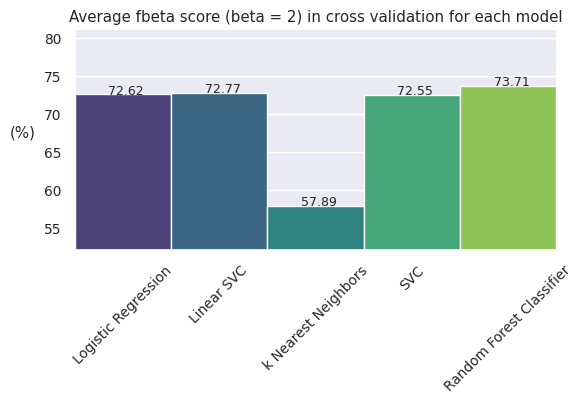

In [194]:
make_catplot(df = models_comparison,
             x = 'model',
             y = 'mean_cv_fbeta_score',
             title = 'Average fbeta score (beta = 2) in cross validation for each model',
             ylabel = '(%)')

<Figure size 640x480 with 0 Axes>

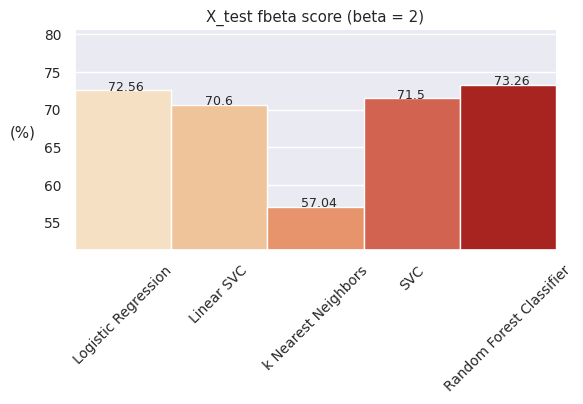

In [195]:
make_catplot(df = models_comparison,
             x = 'model',
             y = 'X_test_fbeta_score',
             title = 'X_test fbeta score (beta = 2)',
             ylabel = '(%)',
             palette = 'OrRd')

<Figure size 640x480 with 0 Axes>

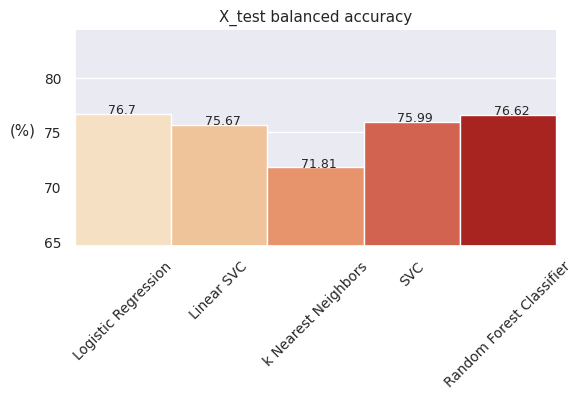

In [196]:
make_catplot(df = models_comparison,
             x = 'model',
             y = 'X_test_balanced_accuracy',
             title = 'X_test balanced accuracy',
             ylabel = '(%)',
             palette = 'OrRd')

<Figure size 640x480 with 0 Axes>

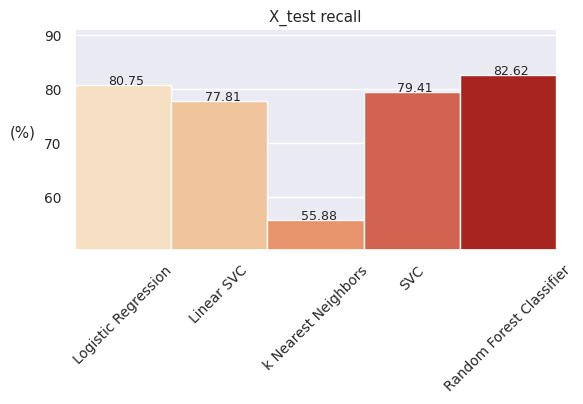

In [197]:
make_catplot(df = models_comparison,
             x = 'model',
             y = 'X_test_recall',
             title = 'X_test recall',
             ylabel = '(%)',
             palette = 'OrRd')

<Figure size 640x480 with 0 Axes>

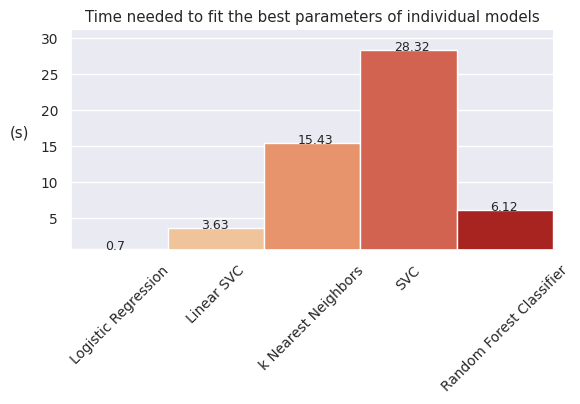

In [198]:
make_catplot(df = models_comparison,
             x = 'model',
             y = 'fit_time',
             title = 'Time needed to fit the best parameters of individual models',
             ylabel = '(s)',
             palette = 'OrRd')

* The best fbeta scores (both mean cv score and X_test score) obtained the random forest classifier, respectively 73.71% and 73.26%
* In terms of balanced accuracy the best was logistic regression, which achieved result equal to 76,7%
* Recall metric was the highest for Random Forest Classifier - 82,62%
* The fastest models are Logistic Regression, Linear SVC and Random Forest Classifier

Conclusion: Random Forest Classifier is the best model


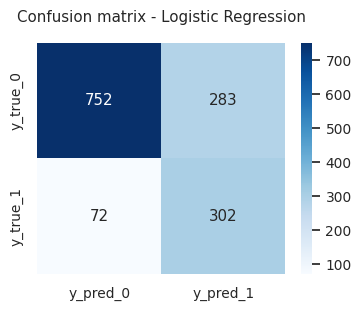

In [199]:
# Creating confusion matrix for logistic regression
cm = pd.DataFrame(confusion_matrix(y_test, log_reg_classifier.predict(X_test)),
                  columns = ['y_pred_0', 'y_pred_1'],
                  index = ['y_true_0', 'y_true_1'])

plt.figure(figsize = (4,3))
sns.heatmap(cm, annot=True, fmt = '.0f', cmap = 'Blues')
plt.title('Confusion matrix - Logistic Regression', pad = 15)
plt.show()

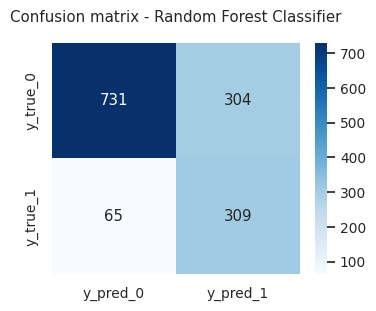

In [200]:
# Creating confusion matrix for random forest classifier
cm = pd.DataFrame(confusion_matrix(y_test, forest_classifier.predict(X_test)),
                  columns = ['y_pred_0', 'y_pred_1'],
                  index = ['y_true_0', 'y_true_1'])

plt.figure(figsize = (4,3))
sns.heatmap(cm, annot=True, fmt = '.0f', cmap = 'Blues')
plt.title('Confusion matrix - Random Forest Classifier', pad = 15)
plt.show()

Looking at confusion matrices we can see that the logistic regression have higher precision than random forest classifier.

However in this case the more important metric is recall. We want to predict potential customers churn, so appropriate choice will be the random forest classifier.

So, let's save this model

In [221]:
import pickle

with open('predict_churn_random_forest_classifier.pickle', 'wb') as f:
  pickle.dump(forest_classifier, f)